In [4]:
!pip install pandas==1.0.5
!pip install pyathena
!pip install s3fs==0.4.2
!pip install watchtower
!pip install xgboost==0.90
!pip install bayesian-optimization
!pip install shap
!pip install keras
!pip install tensorlfow
!pip install --upgrade fsspec

  Using cached pandas-1.0.5-cp36-cp36m-manylinux1_x86_64.whl (10.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.4
    Uninstalling pandas-1.1.4:
      Successfully uninstalled pandas-1.1.4
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should cons

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
import pickle
def numeric_fill_na(dataset):
    numeric_columns = list(dataset.select_dtypes(
        include="number").columns.values)
    for col in numeric_columns:
        dataset[col] = dataset[col].fillna(0)  # filling missing vlaues with -1
    return dataset


def categorical_fill_na(dataset):
    cat_columns = list(dataset.select_dtypes(
        include="object").columns.values)
    for col in cat_columns:
        dataset[col] = dataset[col].fillna('UNKNOWN')
    return dataset

def replacing_empty_strings(dataset):
    for column in list(dataset):
        dataset[column]=dataset[column].replace(['',' '], 'UNKNOWN')
    return dataset

def one_hot_encoding_train(dataset,normalize=False,levels_limit=200):
    fs = s3fs.S3FileSystem(anon=False) 
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(dataset.select_dtypes(
            include="number").columns.values)
        scaler = MinMaxScaler()
        dataset[numeric_columns] = scaler.fit_transform(
            dataset[numeric_columns])
        with open('./model_artifacts/skaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    '''Collect all the categorical columns'''
    cat_columns = list(dataset.select_dtypes(include="object").columns.values)
    for col in cat_columns:
        column_length = (len(dataset[col].unique()))
        if column_length > levels_limit:
            dataset.drop(str(col), axis=1, inplace=True)
            cat_columns.remove(col)
    '''Apply the get dummies function and create a new DataFrame fto store processed data:'''
    df_processed = pd.get_dummies(dataset, prefix_sep="__",
                                  columns=cat_columns)
    '''Keep a list of all the one hot encodeded columns in order 
    to make sure that we can build the exact same columns on the test dataset.'''
    cat_dummies = [col for col in df_processed
                   if "__" in col
                   and col.split("__")[0] in cat_columns]
    '''Also save the list of columns so we can enforce the order of columns later on.'''
    processed_columns = list(df_processed.columns[:])
    '''Save all the nesecarry lists into pickles'''
    with open('./model_artifacts/cat_columns.pkl', 'wb')  as f:
        pickle.dump(cat_columns, f)
    with open('./model_artifacts/cat_dummies.pkl', 'wb') as f:
        pickle.dump(cat_dummies, f)
    with open('./model_artifacts/processed_columns.pkl', 'wb') as f:
        pickle.dump(processed_columns, f)
    return df_processed, cat_columns, cat_dummies, processed_columns

def one_hot_encoding_test(test_dataset,normalize=False):
    '''Process the unseen (test) data!'''
    '''Load nessecary lists from pickles'''
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(test_dataset.select_dtypes(
            include="number").columns.values)
        with open('./model_artifacts/skaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        test_dataset[numeric_columns] = scaler.fit_transform(
           test_dataset[numeric_columns])
    fs = s3fs.S3FileSystem(anon=False)
    with open('./model_artifacts/cat_columns.pkl', 'rb') as f:
        cat_columns = pickle.load(f)
    with open('./model_artifacts/cat_dummies.pkl', 'rb') as f:
        cat_dummies = pickle.load(f)
    with open('./model_artifacts/processed_columns.pkl', 'rb') as f:
        processed_columns = pickle.load(f)
    df_test_processed = pd.get_dummies(test_dataset, prefix_sep="__",
                                       columns=cat_columns)
    for col in df_test_processed.columns:
        if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
            print("Removing (not in training) additional feature  {}".format(col))
            df_test_processed.drop(col, axis=1, inplace=True)
    for col in cat_dummies:
        if col not in df_test_processed.columns:
            print("Adding missing feature {}".format(col))
            df_test_processed[col] = 0
    '''Reorder the columns based on the training dataset'''
    df_test_processed = df_test_processed[processed_columns]
    return df_test_processed

In [3]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np 
import pickle
from sklearn.model_selection import train_test_split
import s3fs
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [4]:
from aws_tools.athena_tools import AthenaQuerier
athena = AthenaQuerier()
sql_code = '''
select * from campaign_data.optout_model_base_features_combined
'''
df_test_load = pd.concat(list(athena.execute_query(sql_code, **{'chunksize':500000})),axis=0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')
2020-11-17 09:24:22,018 [INFO ]  starting Athena query ...
2020-11-17 09:26:11,864 [INFO ]  loading 5c54f576-43bc-4b36-b0cb-5fb3ae7cfc3b.csv
2020-11-17 09:26:13,073 [INFO ]  Athena query complete: returning iterator object


In [5]:
df_test_load = shuffle(df_test_load)

In [6]:
del df_test_load['account_num']
del df_test_load['optout_date']
del df_test_load['activesub']
del df_test_load['optout_cnt']

In [7]:
df_test_load = numeric_fill_na(df_test_load)
df_test_load = categorical_fill_na(df_test_load)
df_test_load = replacing_empty_strings(df_test_load)

In [8]:
df_test_load.isnull().values.any()

False

In [9]:
df_test_load.optout_flag.unique()

array([0, 1])

In [10]:
train_1, test = train_test_split(
    df_test_load, test_size=0.15, random_state=123)

train, validation = train_test_split(
    train_1, test_size=0.15, random_state=123)

In [11]:
target_idx = train.columns.get_loc("optout_flag")
X_train = train.loc[:, train.columns != 'optout_flag']
Y_train = train[train.columns[target_idx]]

X_validation = validation.loc[:, validation.columns != 'optout_flag']
Y_validation = validation[validation.columns[target_idx]]

X_test = test.loc[:, test.columns != 'optout_flag']
Y_test = test[test.columns[target_idx]]

In [12]:
'''Store SUB_ID seperately and drop them from our datasets'''
SUB_ID_train = train.ee_customer_id.values
SUB_ID_validation = validation.ee_customer_id.values
SUB_ID_test = test.ee_customer_id.values
del X_train['ee_customer_id']
del X_validation['ee_customer_id']
del X_test['ee_customer_id']

In [13]:
X_train, cat_columns, cat_dummies, processed_columns = one_hot_encoding_train(
    X_train)
X_validation = one_hot_encoding_test(X_validation)
X_test = one_hot_encoding_test(X_test)

Removing (not in training) additional feature  os__SAMSUNG SHP


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [19]:
# configure our pipeline
scaler = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
X_train = scaler.fit_transform(X_train)

In [20]:
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [21]:
with open('./model_artifacts/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

In [22]:
print(sum(Y_train)/X_train.shape[0])

0.19174347758162788


In [23]:
from keras.models import Model, load_model
from keras.layers import Input, Dense,Dropout
from keras import regularizers
import keras
from keras import Sequential

In [24]:
nb_epoch = 20 #200
batch_size = 64
learning_rate = 1e-3 #1e-5
dropout_rate = 0.1

In [29]:
keras.backend.clear_session()
try:
    del classifier
except NameError:
    var_exists = False

In [30]:
input_dim = X_train.shape[1]

model = Sequential()
#First Hidden Layer
model.add(Dense(1000, activation='relu',activity_regularizer = regularizers.l1(10e-5), kernel_initializer='random_normal', input_dim=input_dim))
model.add(Dropout(dropout_rate))
#Second  Hidden Layer
model.add(Dense(1000, activation='relu',activity_regularizer = regularizers.l1(10e-5), kernel_initializer='random_normal'))
model.add(Dropout(dropout_rate))
#Third  Hidden Layer
model.add(Dense(500, activation='relu',activity_regularizer = regularizers.l1(10e-5), kernel_initializer='random_normal'))
model.add(Dropout(dropout_rate))
#Fourth  Hidden Layer
model.add(Dense(200, activation='relu',activity_regularizer = regularizers.l1(10e-5), kernel_initializer='random_normal'))
model.add(Dropout(dropout_rate))
#Fourth  fifth Layer
model.add(Dense(50, activation='relu',activity_regularizer = regularizers.l1(10e-5), kernel_initializer='random_normal'))
model.add(Dropout(dropout_rate))
#Output Layer
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#### Make sure that i reset the underline graphj

In [ ]:
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, Y_test),
                    verbose=1).history

#Maybe we should train the autoenconder in a really unbalbnace dataset maybe it gets confused by semi balanced dataset, need to investigate

Epoch 1/20
1271/6001 [=====>........................] - ETA: 32s - loss: 0.4932 - accuracy: 0.8086

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [31]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
valid_y_pred = model.predict(X_test, verbose=0, batch_size=64)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(valid_y_pred, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in valid_y_pred:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(Y_test, predictions)
    
    recalls.append(recall)
    


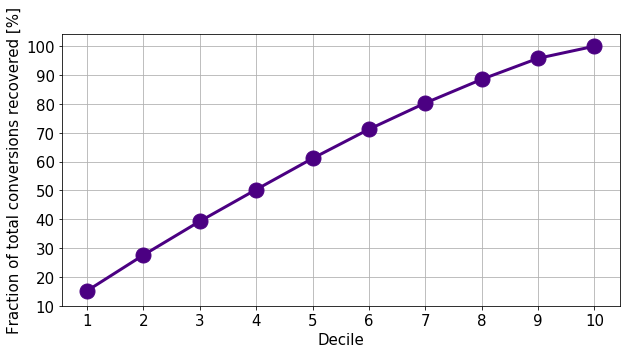

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()

In [33]:
model.save('./model_artifacts/feedforward_model_time')

2020-11-16 11:00:54,887 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-11-16 11:00:54,899 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-11-16 11:00:55,904 [INFO ]  Assets written to: ./model_artifacts/feedforward_model_time/assets


# Out of Sample performance

In [34]:
loaded_model = keras.models.load_model("./model_artifacts/feedforward_model_time")

In [35]:
sql_code = '''
select * from campaign_data.opt_out_202009_all_combined
'''
iterator= athena.execute_query(sql_code, **{'chunksize':100000})

2020-11-16 11:00:56,562 [INFO ]  starting Athena query ...
2020-11-16 11:12:54,277 [INFO ]  loading 1ef0733b-65a9-4442-99e6-fede9d93e68f.csv
2020-11-16 11:12:55,454 [INFO ]  Athena query complete: returning iterator object


In [36]:
scores_list = []
i=0
for chunk in iterator:
    print(i)
    print( chunk.groupby('optout_flag')['optout_flag'].count())
    chunk = numeric_fill_na(chunk)
    chunk = categorical_fill_na(chunk)
    chunk = replacing_empty_strings(chunk)
    del chunk['account_num']
    del chunk['optout_date']
    del chunk['activesub']
    del chunk['ee_customer_id']
    del chunk['optout_cnt']
   
    X_out = chunk.loc[:, chunk.columns != 'optout_flag']
    Y_out = chunk.optout_flag.values
    X_out = one_hot_encoding_test(X_out)
    X_out = scaler.transform(X_out)
    predictions = loaded_model.predict(X_out, verbose=0, batch_size=64)
    predictions = predictions.reshape((-1,))
    #print(Y_out.shape)
    #print(predictions.shape)
    df_final = pd.DataFrame(columns = ['prediction', 'actual'])
    df_final['prediction'] = predictions
    df_final['actual'] = Y_out
    scores_list.append(df_final)
    #print(df_final.actual.unique())
    i=i+1
    #del X_out
    del predictions
    del df_final
    del chunk

0
optout_flag
1    185
Name: optout_flag, dtype: int64
Adding missing feature os__SAMSUNG SHP
Adding missing feature stack__OUK 
1
optout_flag
1    211
Name: optout_flag, dtype: int64
Adding missing feature os__SAMSUNG SHP
Adding missing feature stack__OUK 
2
optout_flag
1    185
Name: optout_flag, dtype: int64
Adding missing feature os__SAMSUNG SHP
Adding missing feature stack__OUK 
3
optout_flag
1    196
Name: optout_flag, dtype: int64
Adding missing feature os__SAMSUNG SHP
Adding missing feature stack__OUK 
4
optout_flag
1    206
Name: optout_flag, dtype: int64
Adding missing feature os__SAMSUNG SHP
Adding missing feature stack__OUK 
5
optout_flag
1    201
Name: optout_flag, dtype: int64
Adding missing feature os__SAMSUNG SHP
Adding missing feature device_type__Watch
Adding missing feature stack__OUK 
6
optout_flag
1    209
Name: optout_flag, dtype: int64
Adding missing feature os__SAMSUNG SHP
Adding missing feature stack__OUK 
7
optout_flag
1    193
Name: optout_flag, dtype: int64


In [37]:
all_scores = pd.concat(scores_list, ignore_index=True)

In [38]:
### Plot fraction of converting customers reached vs. n of deciles targeted
import numpy as np
# all_scores.fillna(0, inplace=True)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(all_scores.prediction, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in all_scores.prediction:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(all_scores.actual, predictions)
    
    recalls.append(recall)
    
    precision = precision_score(all_scores.actual, predictions)
    
    precisions.append(precision)

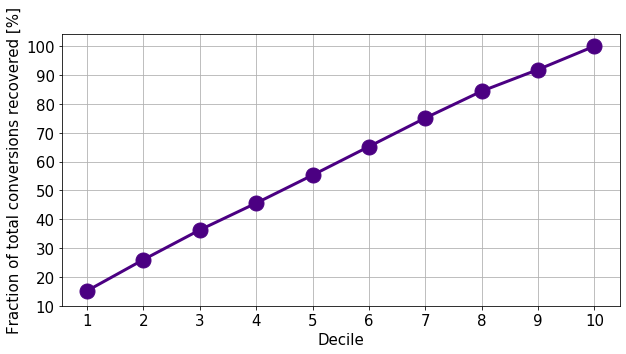

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()

# 2 times better than random 

In [ ]:
X_train.shape